## Comparing PHNNs with random or BLA initialisation
The notebook is structured according to these steps:

__Import data and BLA estimation from MATLAB__
- Import and visualise a dataset
- Separate the data into train, validation and test sets
- Import and check the JRGQ matrices from MATLAB

__Verify data with true model__
- Load the cheat_PHNN with the correct matrices and show that the simulated data can be perfectly matched

__Define and train several model classes__
- Train the default PHNN implementation from deepSI_lite
- Train the custom_PHNN
- Train the linear_PHNN
- Train the combined_PHNN

__Compare model class performances__
- Plot the training and validation losses over <font color='red'>_(1000)_</font> epochs
- Plot the qualitative simulation performance <font color='red'>_(all models in 1 plot will probably not be very informative, so instead plot $y_{1}$ simulation and combined n-step error)_</font>
- Summarize findings

In [59]:
import os
import torch
import scipy
import numpy as np
import matplotlib.pyplot as plt

#import deepSI_lite as dsi
from utils import DK_matrix_form, RK4_multistep_integrator, simulate_model, simulate_model_withP, plot_simulation
from MSD_model import custom_PHNN, linear_PHNN, cheat_PHNN, combined_PHNN, fit_model

# Indicate filepath locations for the dataset, JRGQ matrices and the models to be saved:
PATH_DATA = "datasets/TEST_DATASET_GENERATED.pt"
PATH_JRGQ = "matlabIO/W16_BLA_matrices.mat"
PATH_MODEL_lin = "models/W13_linear_fit.pt"
PATH_MODEL_comb = "models/W14_combined_fit.pt"
PATH_MODEL_nonlin = "models/W13_nonlinear_fit.pt"

# Set figure parameters in advance
plt.rcParams['figure.figsize'] = (15, 3)
plt.rcParams['figure.facecolor'] = "eee8e8"
plt.rcParams['legend.framealpha'] = 0.9
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.25

### Import data and BLA estimation from MATLAB
- Import and visualise a dataset
- Separate the data into train, validation and test sets
- Import and check the JRGQ matrices from MATLAB

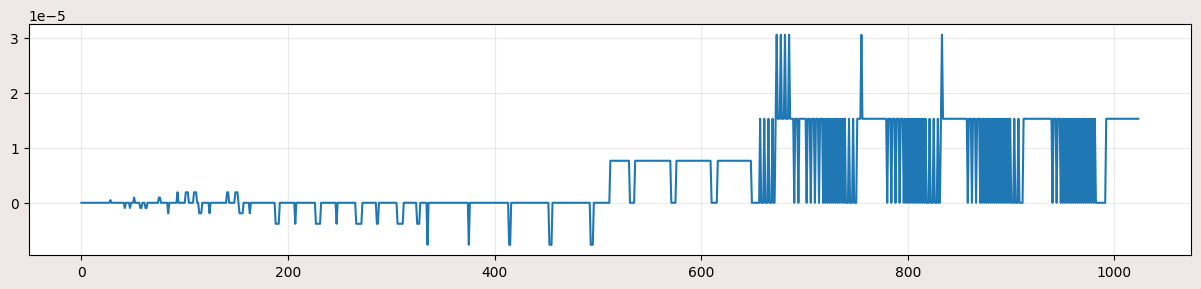

In [60]:
# TODO: Recreate the sim_time vector from data stored in the datasets.pt file
# Current best approximation is 
sim_time = torch.linspace(0, 200, 1024)
dt = sim_time[1]     # To be saved with the file
recreated_time = torch.arange(0, 200+dt, dt)
plt.plot(recreated_time-sim_time)


Number of datasets available: 8


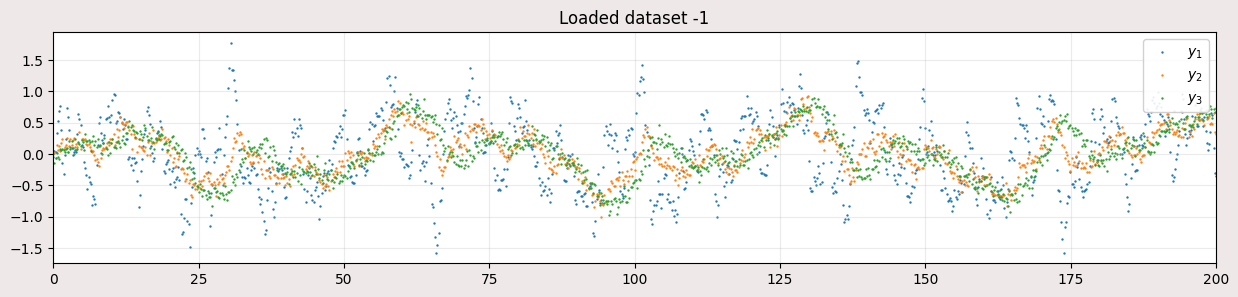

In [61]:
# Import the dataset and visualise the measurements
datasets = torch.load(PATH_DATA, weights_only=False)
print(f"Number of datasets available: {len(datasets)}")

z = -1
plt.scatter(sim_time, datasets[z]["noisy_output"][:, 0], s=0.5)
plt.scatter(sim_time, datasets[z]["noisy_output"][:, 1], s=0.5)
plt.scatter(sim_time, datasets[z]["noisy_output"][:, 2], s=0.5)
plt.legend(["$y_{1}$", "$y_{2}$", "$y_{3}$"], loc=1)
plt.title(f"Loaded dataset {z}")
plt.xlim([0, sim_time[-1]])
plt.show()

In [62]:
# Divide the datasets across training, validation and testing datasets
# The resulting objects are lists of deepSI_lite.Input_output_data objects
n_train = 5
n_val = 2
n_test = 1

dsi_train = []
dsi_val = []
dsi_test = []

for i, set in enumerate(datasets):
    if i < n_train:
        dsi_train.append(set["dsi_IO"])
    elif i < n_train+n_val:
        dsi_val.append(set["dsi_IO"])
    else:
        dsi_test.append(set["dsi_IO"])

In [67]:
# Import the Best Linear Approximation (BLA) of the dataset and check the results:
# NB: this approximation is done through the MATLAB ssest function
matrix_dict = scipy.io.loadmat(PATH_JRGQ)
J = torch.FloatTensor(matrix_dict["J"])
R = torch.FloatTensor(matrix_dict["R"])
G = torch.FloatTensor(matrix_dict["G"])
Q = torch.FloatTensor(matrix_dict["Q"])
P = torch.FloatTensor(matrix_dict["P"])
#print(J, R, G, Q, P)

### Verify data with true model
- Load the cheat_PHNN with the correct matrices and show that the simulated data can be perfectly matched

In [68]:
# Define the true system
x_test = torch.rand(1, 6)
system_dim = torch.IntTensor([[6, 3]])
na = nb = 10

M_vals = torch.FloatTensor([2, 2, 2])
D_vals = torch.FloatTensor([1, 1, 1])
K_vals = torch.FloatTensor([0.5, 0.5, 0.5])
M = torch.diag(M_vals)
D = DK_matrix_form(D_vals)
K = DK_matrix_form(K_vals)

# Initialise the model
cheat_model = cheat_PHNN(system_dim, na, nb, dt=sim_time[1], M=M, D=D, K=K, cubic=False)
#cheat_model.get_matrices(x_test)

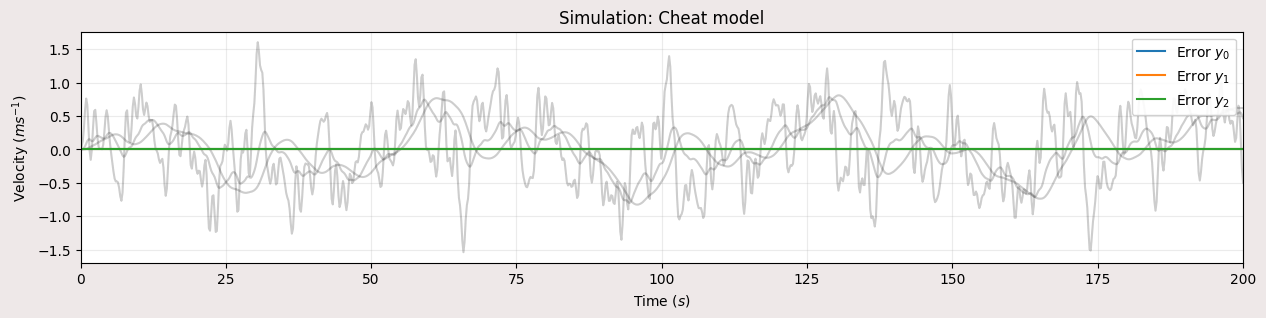

In [69]:
# Simulate the model to check if it fits the data
z = -1
x0 = torch.FloatTensor(datasets[z]["states"][0, :])
u = torch.FloatTensor(datasets[z]["inputs"])
cheat_states, cheat_outputs = simulate_model(sim_time=sim_time, model=cheat_model, x0=x0, u_ext=u)
plot_simulation(sim_time, datasets[z]["output"], cheat_outputs, plot_mode="error", title="Simulation: Cheat model")

### Define and train several model classes
- <font color='red'>_TODO: Train the default PHNN implementation from deepSI_lite_ </font>
- Train the custom_PHNN
- Train the linear_PHNN
- Train the combined_PHNN

In [25]:
# TODO: Train deepSI_lite model

In [26]:
# TODO: Implement lists of datasets as input to the training function

linear_model = linear_PHNN(system_dim, na, nb, dt=sim_time[1])
# If we have a saved model --> no need to train --> instead load the saved model statedict and training info
if os.path.isfile(PATH_MODEL_lin):
    lf_saved = torch.load(PATH_MODEL_lin, weights_only=False)
    linear_model.load_state_dict(lf_saved["state_dict"])
    lf_loss = lf_saved["train_loss"]
    lf_val_loss = lf_saved["val_loss"]
# Otherwise, we have to train the model and save it afterwards
else: 
    lf_loss, lf_val_loss, lf_best_sd = fit_model(linear_model, datasets[0]["dsi_IO"], datasets[0]["dsi_IO"], n_its=1001, T=200, stride=1)
    lf_train = {
        "train_loss":lf_loss,
        "val_loss":lf_val_loss,
        "state_dict":lf_best_sd
    }
    torch.save(lf_train, PATH_MODEL_lin)

In [27]:
nonlinear_model = custom_PHNN(system_dim, na, nb, dt=sim_time[1])

# If we have a saved model --> no need to train --> instead load the saved model statedict and training info
if os.path.isfile(PATH_MODEL_nonlin):
    nlf_saved = torch.load(PATH_MODEL_nonlin, weights_only=False)
    nonlinear_model.load_state_dict(nlf_saved["state_dict"])
    nlf_loss = nlf_saved["train_loss"]
    nlf_val_loss = nlf_saved["val_loss"]
# Otherwise, we have to train the model and save it afterwards
else: 
    nlf_loss, nlf_val_loss, nlf_best_sd = fit_model(nonlinear_model, datasets[0]["dsi_IO"], datasets[0]["dsi_IO"], n_its=1001, T=200, stride=1)
    nlf_train = {
        "train_loss":nlf_loss,
        "val_loss":nlf_val_loss,
        "state_dict":nlf_best_sd
    }
    torch.save(nlf_train, PATH_MODEL_nonlin)

In [75]:
combined_model = combined_PHNN(system_dim, na, nb, dt=sim_time[1], x0=x_test,
                               Jinit=J,
                               Rinit=R,
                               Ginit=G,
                               Qinit=Q,
                               Pinit=P,
                               custom_kwargs={})

# Qualitative results of the linear model before training
comb_states, comb_outputs = simulate_model_withP(sim_time=sim_time, model=combined_model, x0=x0, u_ext=u)
plot_simulation(sim_time, datasets[z]["output"], comb_outputs, plot_mode="error", title="Simulation: BLA initialised model")

# Attempt at only training the encoder:
for name, layer in combined_model.named_children():
    if name == "enc_net":
        for param in layer.parameters():
            param.requires_grad = True
    else:
        for param in layer.parameters():
            param.requires_grad = False

# Check to see if they are really turned off
for param in combined_model.parameters():
    print(param.requires_grad)


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True


In [76]:
cf_loss, cf_val_loss, cf_best_sd = fit_model(combined_model, datasets[0]["dsi_IO"], datasets[1]["dsi_IO"], n_its=10001, T=1, val_freq=100)

  0%|          | 3/10001 [00:00<07:53, 21.13it/s]

Iteration       0, with training loss (NRMSE): 1.27245 and validation loss (NRMSE): 0.94065 === NEW BEST VALIDATION!


  1%|          | 105/10001 [00:04<07:13, 22.81it/s]

Iteration     100, with training loss (NRMSE): 0.01746 and validation loss (NRMSE): 0.01715 === NEW BEST VALIDATION!


  2%|▏         | 204/10001 [00:08<07:01, 23.27it/s]

Iteration     200, with training loss (NRMSE): 0.00933 and validation loss (NRMSE): 0.00938 === NEW BEST VALIDATION!


  3%|▎         | 303/10001 [00:13<08:14, 19.63it/s]

Iteration     300, with training loss (NRMSE): 0.00763 and validation loss (NRMSE): 0.00709 === NEW BEST VALIDATION!


  4%|▍         | 404/10001 [00:17<07:21, 21.76it/s]

Iteration     400, with training loss (NRMSE): 0.00608 and validation loss (NRMSE): 0.00602 === NEW BEST VALIDATION!


  5%|▌         | 505/10001 [00:22<07:53, 20.05it/s]

Iteration     500, with training loss (NRMSE): 0.00577 and validation loss (NRMSE): 0.00539


  6%|▌         | 604/10001 [00:27<06:37, 23.63it/s]

Iteration     600, with training loss (NRMSE): 0.00560 and validation loss (NRMSE): 0.00498


  7%|▋         | 703/10001 [00:31<06:42, 23.11it/s]

Iteration     700, with training loss (NRMSE): 0.00655 and validation loss (NRMSE): 0.00465 === NEW BEST VALIDATION!


  8%|▊         | 805/10001 [00:35<06:53, 22.23it/s]

Iteration     800, with training loss (NRMSE): 0.00471 and validation loss (NRMSE): 0.00443


  9%|▉         | 903/10001 [00:40<08:03, 18.81it/s]

Iteration     900, with training loss (NRMSE): 0.00396 and validation loss (NRMSE): 0.00426


 10%|█         | 1005/10001 [00:45<06:53, 21.74it/s]

Iteration   1,000, with training loss (NRMSE): 0.00534 and validation loss (NRMSE): 0.00409 === NEW BEST VALIDATION!


 11%|█         | 1104/10001 [00:49<06:27, 22.98it/s]

Iteration   1,100, with training loss (NRMSE): 0.00362 and validation loss (NRMSE): 0.00397


 12%|█▏        | 1205/10001 [00:54<07:16, 20.15it/s]

Iteration   1,200, with training loss (NRMSE): 0.00572 and validation loss (NRMSE): 0.00387


 13%|█▎        | 1305/10001 [00:59<06:47, 21.34it/s]

Iteration   1,300, with training loss (NRMSE): 0.00380 and validation loss (NRMSE): 0.00376


 14%|█▍        | 1403/10001 [01:05<08:05, 17.72it/s]

Iteration   1,400, with training loss (NRMSE): 0.00481 and validation loss (NRMSE): 0.00367


 15%|█▌        | 1504/10001 [01:10<07:57, 17.81it/s]

Iteration   1,500, with training loss (NRMSE): 0.00379 and validation loss (NRMSE): 0.00360


 16%|█▌        | 1603/10001 [01:16<06:59, 20.04it/s]

Iteration   1,600, with training loss (NRMSE): 0.00356 and validation loss (NRMSE): 0.00359


 17%|█▋        | 1705/10001 [01:20<06:00, 23.04it/s]

Iteration   1,700, with training loss (NRMSE): 0.00356 and validation loss (NRMSE): 0.00358


 18%|█▊        | 1804/10001 [01:25<05:59, 22.81it/s]

Iteration   1,800, with training loss (NRMSE): 0.00347 and validation loss (NRMSE): 0.00341


 19%|█▉        | 1903/10001 [01:29<05:33, 24.26it/s]

Iteration   1,900, with training loss (NRMSE): 0.00444 and validation loss (NRMSE): 0.00338


 20%|██        | 2005/10001 [01:33<06:19, 21.09it/s]

Iteration   2,000, with training loss (NRMSE): 0.00348 and validation loss (NRMSE): 0.00330


 21%|██        | 2104/10001 [01:37<05:16, 24.91it/s]

Iteration   2,100, with training loss (NRMSE): 0.00403 and validation loss (NRMSE): 0.00328


 22%|██▏       | 2206/10001 [01:41<05:05, 25.51it/s]

Iteration   2,200, with training loss (NRMSE): 0.00340 and validation loss (NRMSE): 0.00328


 23%|██▎       | 2305/10001 [01:45<05:05, 25.16it/s]

Iteration   2,300, with training loss (NRMSE): 0.00352 and validation loss (NRMSE): 0.00320


 24%|██▍       | 2404/10001 [01:50<05:54, 21.44it/s]

Iteration   2,400, with training loss (NRMSE): 0.00358 and validation loss (NRMSE): 0.00306 === NEW BEST VALIDATION!


 25%|██▌       | 2503/10001 [01:54<05:08, 24.31it/s]

Iteration   2,500, with training loss (NRMSE): 0.00359 and validation loss (NRMSE): 0.00306


 26%|██▌       | 2602/10001 [01:58<05:04, 24.28it/s]

Iteration   2,600, with training loss (NRMSE): 0.00308 and validation loss (NRMSE): 0.00303


 27%|██▋       | 2704/10001 [02:02<05:13, 23.31it/s]

Iteration   2,700, with training loss (NRMSE): 0.00313 and validation loss (NRMSE): 0.00293


 28%|██▊       | 2806/10001 [02:07<04:49, 24.87it/s]

Iteration   2,800, with training loss (NRMSE): 0.00410 and validation loss (NRMSE): 0.00301


 29%|██▉       | 2905/10001 [02:12<04:48, 24.63it/s]

Iteration   2,900, with training loss (NRMSE): 0.00306 and validation loss (NRMSE): 0.00296


 30%|███       | 3004/10001 [02:16<04:44, 24.58it/s]

Iteration   3,000, with training loss (NRMSE): 0.00292 and validation loss (NRMSE): 0.00283


 31%|███       | 3103/10001 [02:20<05:41, 20.21it/s]

Iteration   3,100, with training loss (NRMSE): 0.00385 and validation loss (NRMSE): 0.00274


 32%|███▏      | 3203/10001 [02:25<05:00, 22.61it/s]

Iteration   3,200, with training loss (NRMSE): 0.00320 and validation loss (NRMSE): 0.00273


 33%|███▎      | 3305/10001 [02:29<04:43, 23.61it/s]

Iteration   3,300, with training loss (NRMSE): 0.00361 and validation loss (NRMSE): 0.00266


 34%|███▍      | 3404/10001 [02:33<04:25, 24.86it/s]

Iteration   3,400, with training loss (NRMSE): 0.00266 and validation loss (NRMSE): 0.00263


 35%|███▌      | 3506/10001 [02:37<04:11, 25.85it/s]

Iteration   3,500, with training loss (NRMSE): 0.00346 and validation loss (NRMSE): 0.00260


 36%|███▌      | 3605/10001 [02:41<04:13, 25.19it/s]

Iteration   3,600, with training loss (NRMSE): 0.00295 and validation loss (NRMSE): 0.00246 === NEW BEST VALIDATION!


 37%|███▋      | 3704/10001 [02:45<04:11, 25.07it/s]

Iteration   3,700, with training loss (NRMSE): 0.00344 and validation loss (NRMSE): 0.00245 === NEW BEST VALIDATION!


 38%|███▊      | 3803/10001 [02:49<04:09, 24.87it/s]

Iteration   3,800, with training loss (NRMSE): 0.00241 and validation loss (NRMSE): 0.00243


 39%|███▉      | 3905/10001 [02:53<03:57, 25.71it/s]

Iteration   3,900, with training loss (NRMSE): 0.00289 and validation loss (NRMSE): 0.00235


 40%|████      | 4004/10001 [02:58<04:31, 22.08it/s]

Iteration   4,000, with training loss (NRMSE): 0.00278 and validation loss (NRMSE): 0.00231


 41%|████      | 4106/10001 [03:02<04:00, 24.47it/s]

Iteration   4,100, with training loss (NRMSE): 0.00351 and validation loss (NRMSE): 0.00240


 42%|████▏     | 4205/10001 [03:06<03:51, 25.06it/s]

Iteration   4,200, with training loss (NRMSE): 0.00226 and validation loss (NRMSE): 0.00237


 43%|████▎     | 4304/10001 [03:10<03:43, 25.44it/s]

Iteration   4,300, with training loss (NRMSE): 0.00253 and validation loss (NRMSE): 0.00222


 44%|████▍     | 4403/10001 [03:14<03:47, 24.57it/s]

Iteration   4,400, with training loss (NRMSE): 0.00278 and validation loss (NRMSE): 0.00215


 45%|████▌     | 4505/10001 [03:18<04:03, 22.61it/s]

Iteration   4,500, with training loss (NRMSE): 0.00204 and validation loss (NRMSE): 0.00209


 46%|████▌     | 4604/10001 [03:23<03:51, 23.27it/s]

Iteration   4,600, with training loss (NRMSE): 0.00205 and validation loss (NRMSE): 0.00211


 47%|████▋     | 4703/10001 [03:27<03:51, 22.85it/s]

Iteration   4,700, with training loss (NRMSE): 0.00228 and validation loss (NRMSE): 0.00201


 48%|████▊     | 4805/10001 [03:31<03:44, 23.10it/s]

Iteration   4,800, with training loss (NRMSE): 0.00264 and validation loss (NRMSE): 0.00201


 49%|████▉     | 4904/10001 [03:35<03:33, 23.87it/s]

Iteration   4,900, with training loss (NRMSE): 0.00203 and validation loss (NRMSE): 0.00207


 50%|█████     | 5003/10001 [03:40<05:25, 15.34it/s]

Iteration   5,000, with training loss (NRMSE): 0.00221 and validation loss (NRMSE): 0.00187 === NEW BEST VALIDATION!


 51%|█████     | 5103/10001 [03:45<03:25, 23.79it/s]

Iteration   5,100, with training loss (NRMSE): 0.00199 and validation loss (NRMSE): 0.00190


 52%|█████▏    | 5205/10001 [03:49<03:13, 24.80it/s]

Iteration   5,200, with training loss (NRMSE): 0.00256 and validation loss (NRMSE): 0.00195


 53%|█████▎    | 5304/10001 [03:53<03:21, 23.28it/s]

Iteration   5,300, with training loss (NRMSE): 0.00209 and validation loss (NRMSE): 0.00175


 54%|█████▍    | 5403/10001 [03:58<03:06, 24.64it/s]

Iteration   5,400, with training loss (NRMSE): 0.00216 and validation loss (NRMSE): 0.00170 === NEW BEST VALIDATION!


 55%|█████▌    | 5505/10001 [04:02<03:05, 24.25it/s]

Iteration   5,500, with training loss (NRMSE): 0.00184 and validation loss (NRMSE): 0.00176


 56%|█████▌    | 5604/10001 [04:06<02:53, 25.32it/s]

Iteration   5,600, with training loss (NRMSE): 0.00236 and validation loss (NRMSE): 0.00175


 57%|█████▋    | 5703/10001 [04:10<02:48, 25.52it/s]

Iteration   5,700, with training loss (NRMSE): 0.00151 and validation loss (NRMSE): 0.00160


 58%|█████▊    | 5805/10001 [04:14<02:56, 23.74it/s]

Iteration   5,800, with training loss (NRMSE): 0.00220 and validation loss (NRMSE): 0.00160


 59%|█████▉    | 5904/10001 [04:19<02:48, 24.34it/s]

Iteration   5,900, with training loss (NRMSE): 0.00151 and validation loss (NRMSE): 0.00157


 60%|██████    | 6003/10001 [04:23<02:53, 23.00it/s]

Iteration   6,000, with training loss (NRMSE): 0.00153 and validation loss (NRMSE): 0.00157


 61%|██████    | 6105/10001 [04:27<02:43, 23.81it/s]

Iteration   6,100, with training loss (NRMSE): 0.00150 and validation loss (NRMSE): 0.00149


 62%|██████▏   | 6204/10001 [04:31<02:39, 23.78it/s]

Iteration   6,200, with training loss (NRMSE): 0.00178 and validation loss (NRMSE): 0.00146


 63%|██████▎   | 6306/10001 [04:36<02:33, 24.07it/s]

Iteration   6,300, with training loss (NRMSE): 0.00209 and validation loss (NRMSE): 0.00149


 64%|██████▍   | 6405/10001 [04:40<02:30, 23.86it/s]

Iteration   6,400, with training loss (NRMSE): 0.00178 and validation loss (NRMSE): 0.00136


 65%|██████▌   | 6504/10001 [04:44<02:26, 23.86it/s]

Iteration   6,500, with training loss (NRMSE): 0.00195 and validation loss (NRMSE): 0.00135


 66%|██████▌   | 6606/10001 [04:48<02:15, 24.98it/s]

Iteration   6,600, with training loss (NRMSE): 0.00197 and validation loss (NRMSE): 0.00134


 67%|██████▋   | 6705/10001 [04:52<02:10, 25.25it/s]

Iteration   6,700, with training loss (NRMSE): 0.00122 and validation loss (NRMSE): 0.00130


 68%|██████▊   | 6804/10001 [04:56<02:05, 25.48it/s]

Iteration   6,800, with training loss (NRMSE): 0.00146 and validation loss (NRMSE): 0.00122


 69%|██████▉   | 6906/10001 [05:00<02:03, 25.06it/s]

Iteration   6,900, with training loss (NRMSE): 0.00135 and validation loss (NRMSE): 0.00127


 70%|███████   | 7005/10001 [05:04<01:55, 25.87it/s]

Iteration   7,000, with training loss (NRMSE): 0.00145 and validation loss (NRMSE): 0.00120


 71%|███████   | 7104/10001 [05:08<01:52, 25.64it/s]

Iteration   7,100, with training loss (NRMSE): 0.00126 and validation loss (NRMSE): 0.00119


 72%|███████▏  | 7206/10001 [05:13<01:48, 25.71it/s]

Iteration   7,200, with training loss (NRMSE): 0.00164 and validation loss (NRMSE): 0.00120


 73%|███████▎  | 7305/10001 [05:17<01:57, 22.86it/s]

Iteration   7,300, with training loss (NRMSE): 0.00137 and validation loss (NRMSE): 0.00118


 74%|███████▍  | 7404/10001 [05:21<01:51, 23.24it/s]

Iteration   7,400, with training loss (NRMSE): 0.00125 and validation loss (NRMSE): 0.00105


 75%|███████▌  | 7503/10001 [05:25<01:49, 22.88it/s]

Iteration   7,500, with training loss (NRMSE): 0.00109 and validation loss (NRMSE): 0.00106


 76%|███████▌  | 7605/10001 [05:29<01:39, 24.10it/s]

Iteration   7,600, with training loss (NRMSE): 0.00112 and validation loss (NRMSE): 0.00100


 77%|███████▋  | 7704/10001 [05:33<01:34, 24.25it/s]

Iteration   7,700, with training loss (NRMSE): 0.00150 and validation loss (NRMSE): 0.00101


 78%|███████▊  | 7803/10001 [05:38<01:43, 21.25it/s]

Iteration   7,800, with training loss (NRMSE): 0.00103 and validation loss (NRMSE): 0.00099


 79%|███████▉  | 7905/10001 [05:42<01:25, 24.50it/s]

Iteration   7,900, with training loss (NRMSE): 0.00104 and validation loss (NRMSE): 0.00091 === NEW BEST VALIDATION!


 80%|████████  | 8004/10001 [05:46<01:21, 24.49it/s]

Iteration   8,000, with training loss (NRMSE): 0.00106 and validation loss (NRMSE): 0.00092


 81%|████████  | 8103/10001 [05:51<01:21, 23.42it/s]

Iteration   8,100, with training loss (NRMSE): 0.00104 and validation loss (NRMSE): 0.00092


 82%|████████▏ | 8205/10001 [05:55<01:12, 24.82it/s]

Iteration   8,200, with training loss (NRMSE): 0.00100 and validation loss (NRMSE): 0.00083 === NEW BEST VALIDATION!


 83%|████████▎ | 8304/10001 [05:59<01:16, 22.04it/s]

Iteration   8,300, with training loss (NRMSE): 0.00100 and validation loss (NRMSE): 0.00083


 84%|████████▍ | 8403/10001 [06:04<01:09, 22.99it/s]

Iteration   8,400, with training loss (NRMSE): 0.00088 and validation loss (NRMSE): 0.00084


 85%|████████▌ | 8505/10001 [06:08<01:04, 23.34it/s]

Iteration   8,500, with training loss (NRMSE): 0.00089 and validation loss (NRMSE): 0.00087


 86%|████████▌ | 8604/10001 [06:12<00:57, 24.21it/s]

Iteration   8,600, with training loss (NRMSE): 0.00087 and validation loss (NRMSE): 0.00078


 87%|████████▋ | 8703/10001 [06:16<00:57, 22.70it/s]

Iteration   8,700, with training loss (NRMSE): 0.00079 and validation loss (NRMSE): 0.00074


 88%|████████▊ | 8805/10001 [06:21<00:49, 24.04it/s]

Iteration   8,800, with training loss (NRMSE): 0.00082 and validation loss (NRMSE): 0.00073


 89%|████████▉ | 8904/10001 [06:25<00:44, 24.72it/s]

Iteration   8,900, with training loss (NRMSE): 0.00064 and validation loss (NRMSE): 0.00068 === NEW BEST VALIDATION!


 90%|█████████ | 9003/10001 [06:29<00:41, 23.91it/s]

Iteration   9,000, with training loss (NRMSE): 0.00071 and validation loss (NRMSE): 0.00070


 91%|█████████ | 9105/10001 [06:33<00:37, 23.59it/s]

Iteration   9,100, with training loss (NRMSE): 0.00082 and validation loss (NRMSE): 0.00068


 92%|█████████▏| 9204/10001 [06:37<00:35, 22.71it/s]

Iteration   9,200, with training loss (NRMSE): 0.00086 and validation loss (NRMSE): 0.00067


 93%|█████████▎| 9306/10001 [06:42<00:28, 24.79it/s]

Iteration   9,300, with training loss (NRMSE): 0.00063 and validation loss (NRMSE): 0.00062 === NEW BEST VALIDATION!


 94%|█████████▍| 9405/10001 [06:46<00:23, 25.09it/s]

Iteration   9,400, with training loss (NRMSE): 0.00091 and validation loss (NRMSE): 0.00085


 95%|█████████▌| 9504/10001 [06:49<00:19, 25.04it/s]

Iteration   9,500, with training loss (NRMSE): 0.00074 and validation loss (NRMSE): 0.00065


 96%|█████████▌| 9606/10001 [06:54<00:15, 25.87it/s]

Iteration   9,600, with training loss (NRMSE): 0.00074 and validation loss (NRMSE): 0.00065


 97%|█████████▋| 9705/10001 [06:58<00:11, 25.43it/s]

Iteration   9,700, with training loss (NRMSE): 0.00082 and validation loss (NRMSE): 0.00061


 98%|█████████▊| 9804/10001 [07:01<00:07, 25.52it/s]

Iteration   9,800, with training loss (NRMSE): 0.00079 and validation loss (NRMSE): 0.00057


 99%|█████████▉| 9906/10001 [07:05<00:03, 25.72it/s]

Iteration   9,900, with training loss (NRMSE): 0.00086 and validation loss (NRMSE): 0.00059


100%|██████████| 10001/10001 [07:09<00:00, 23.28it/s]

Iteration  10,000, with training loss (NRMSE): 0.00072 and validation loss (NRMSE): 0.00054


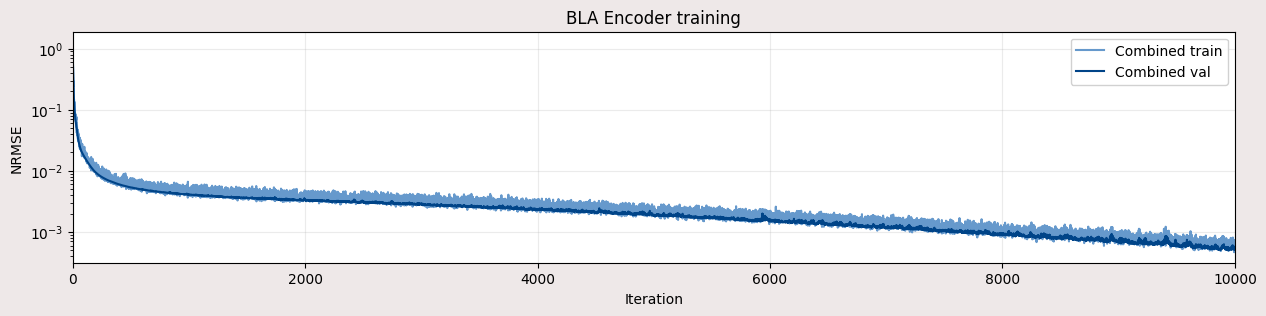

In [80]:
plt.semilogy(cf_loss, label="Combined train", color="#6699CC")
plt.semilogy(cf_val_loss, label="Combined val", color="#004488")

plt.ylabel('NRMSE')
plt.legend(loc=1)
plt.xlabel('Iteration')
plt.xlim([0, max(len(lf_loss), len(nlf_loss), len(cf_loss))])
plt.title("BLA Encoder training")
plt.grid(alpha=0.25)
plt.show()

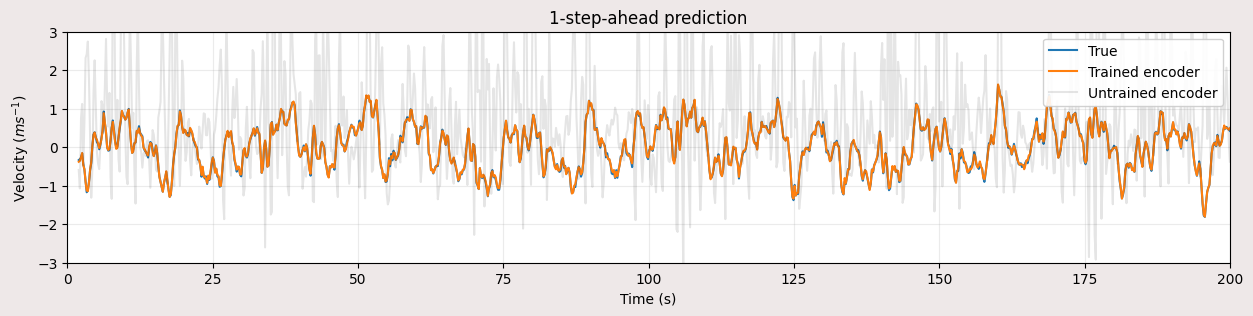

In [92]:
from deepSI_lite.models import past_future_arrays
untrained_combined_model = combined_PHNN(system_dim, na, nb, dt=sim_time[1], x0=x_test,
                               Jinit=J,
                               Rinit=R,
                               Ginit=G,
                               Qinit=Q,
                               Pinit=P,
                               custom_kwargs={})


arrays, indices = past_future_arrays(datasets[1]["dsi_IO"], na=combined_model.na, nb=combined_model.nb, T=1, add_sampling_time=False, stride=1) #transform (u, y) into (u1, y1, u2, y2)
arrays[0].shape
t = 0
u1 = arrays[0]#[0, :, :].view(1, arrays[0].shape[1], arrays[0].shape[2])
y1 = arrays[1]#[0, :, :].view(1, arrays[1].shape[1], arrays[1].shape[2])
u2 = arrays[2]#[0, :, :].view(1, arrays[2].shape[1], arrays[2].shape[2])
y2 = arrays[3][:, t, 0]

# model input must be upast, ypast ufuture
ypred = combined_model(u1, y1, u2).detach().numpy()
untrained_ypred = untrained_combined_model(u1, y1, u2).detach().numpy()
plt.plot(sim_time[10:], y2, label="True")
plt.plot(sim_time[10:], ypred[:, t, 0], label="Trained encoder")
plt.plot(sim_time[10:], untrained_ypred[:, t, 0], "k", alpha=0.1, label="Untrained encoder")
plt.ylim([-3, 3])
plt.xlim([0, sim_time[-1]])
plt.title("1-step-ahead prediction")
plt.ylabel("Velocity ($ms^{-1}$)")
plt.xlabel("Time (s)")
plt.legend(loc=1)
plt.show()

In [98]:
for param in combined_model.Jnet.net_list[0].net[0].parameters():
    print(param.requires_grad)
    if param.requires_grad:
        print("Parameter does require training")
    else:
        print("Parameter does not require training")

    # Attempt at only training the encoder:
for name, layer in combined_model.named_children():
    if name == "enc_net":
        for param in layer.parameters():
            param.requires_grad = False
    else:
        for param in layer.parameters():
            param.requires_grad = True

for param in combined_model.Jnet.net_list[0].net[0].parameters():
    print(param.requires_grad)
    if param.requires_grad:
        print("Parameter does require training")
    else:
        print("Parameter does not require training")

True
Parameter does require training
True
Parameter does require training
True
Parameter does require training
True
Parameter does require training


In [106]:
rest_cf_loss, rest_cf_val_loss, rest_cf_best_sd = fit_model(combined_model, datasets[0]["dsi_IO"], datasets[1]["dsi_IO"], n_its=1001, T=25, val_freq=100)

  0%|          | 1/1001 [00:01<18:53,  1.13s/it]

Iteration       0, with training loss (NRMSE): 0.07746 and validation loss (NRMSE): 0.07395 === NEW BEST VALIDATION!


 10%|█         | 101/1001 [01:59<19:01,  1.27s/it]

Iteration     100, with training loss (NRMSE): 0.01617 and validation loss (NRMSE): 0.01575 === NEW BEST VALIDATION!


 20%|██        | 201/1001 [04:00<15:44,  1.18s/it]

Iteration     200, with training loss (NRMSE): 0.01394 and validation loss (NRMSE): 0.01417 === NEW BEST VALIDATION!


 30%|███       | 301/1001 [06:01<15:31,  1.33s/it]

Iteration     300, with training loss (NRMSE): 0.01243 and validation loss (NRMSE): 0.01302 === NEW BEST VALIDATION!


 40%|████      | 401/1001 [08:01<13:40,  1.37s/it]

Iteration     400, with training loss (NRMSE): 0.01306 and validation loss (NRMSE): 0.01257


 50%|█████     | 501/1001 [10:08<10:12,  1.23s/it]

Iteration     500, with training loss (NRMSE): 0.01198 and validation loss (NRMSE): 0.01194 === NEW BEST VALIDATION!


 60%|██████    | 601/1001 [12:16<08:52,  1.33s/it]

Iteration     600, with training loss (NRMSE): 0.01119 and validation loss (NRMSE): 0.01148


 70%|███████   | 701/1001 [14:20<05:50,  1.17s/it]

Iteration     700, with training loss (NRMSE): 0.01144 and validation loss (NRMSE): 0.01127


 80%|████████  | 801/1001 [16:17<03:51,  1.16s/it]

Iteration     800, with training loss (NRMSE): 0.01034 and validation loss (NRMSE): 0.01061 === NEW BEST VALIDATION!


 90%|█████████ | 901/1001 [18:25<02:07,  1.27s/it]

Iteration     900, with training loss (NRMSE): 0.01099 and validation loss (NRMSE): 0.01066


100%|██████████| 1001/1001 [20:34<00:00,  1.23s/it]

Iteration   1,000, with training loss (NRMSE): 0.01041 and validation loss (NRMSE): 0.01041


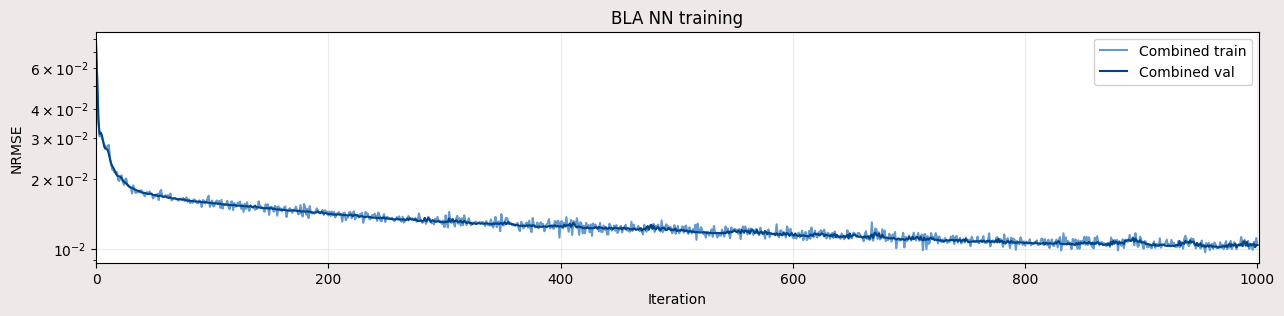

In [107]:
plt.semilogy(rest_cf_loss, label="Combined train", color="#6699CC")
plt.semilogy(rest_cf_val_loss, label="Combined val", color="#004488")

plt.ylabel('NRMSE')
plt.legend(loc=1)
plt.xlabel('Iteration')
plt.xlim([0, max(len(lf_loss), len(nlf_loss), len(rest_cf_loss))])
plt.title("BLA NN training")
plt.grid(alpha=0.25)
plt.show()

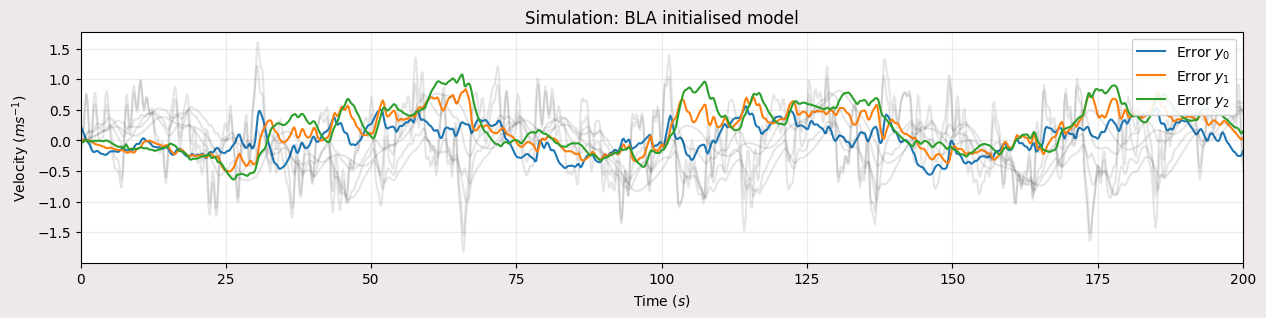

In [108]:
# Qualitative results of the linear model
comb_states, comb_outputs = simulate_model_withP(sim_time=sim_time, model=combined_model, x0=x0, u_ext=u)
plot_simulation(sim_time, datasets[z]["output"], comb_outputs, plot_mode="error", title="Simulation: BLA initialised model")

  0%|          | 1/1001 [00:05<1:28:30,  5.31s/it]

Iteration       0, with training loss (NRMSE): 0.03319 and validation loss (NRMSE): 0.03336 === NEW BEST VALIDATION!


  5%|▌         | 51/1001 [04:14<1:21:27,  5.14s/it]

Iteration      50, with training loss (NRMSE): 0.01172 and validation loss (NRMSE): 0.01124 === NEW BEST VALIDATION!


 10%|█         | 101/1001 [08:20<1:09:19,  4.62s/it]

Iteration     100, with training loss (NRMSE): 0.00989 and validation loss (NRMSE): 0.00988


 15%|█▌        | 151/1001 [12:18<1:13:22,  5.18s/it]

Iteration     150, with training loss (NRMSE): 0.00899 and validation loss (NRMSE): 0.00888 === NEW BEST VALIDATION!


 20%|██        | 201/1001 [16:25<1:07:28,  5.06s/it]

Iteration     200, with training loss (NRMSE): 0.00832 and validation loss (NRMSE): 0.00852


 25%|██▌       | 251/1001 [20:25<59:27,  4.76s/it]  

Iteration     250, with training loss (NRMSE): 0.00781 and validation loss (NRMSE): 0.00824


 30%|███       | 301/1001 [24:29<55:11,  4.73s/it]  

Iteration     300, with training loss (NRMSE): 0.00808 and validation loss (NRMSE): 0.00793


 35%|███▌      | 351/1001 [28:26<52:29,  4.85s/it]

Iteration     350, with training loss (NRMSE): 0.00837 and validation loss (NRMSE): 0.00781


 40%|████      | 401/1001 [32:29<50:10,  5.02s/it]

Iteration     400, with training loss (NRMSE): 0.00726 and validation loss (NRMSE): 0.00753


 45%|████▌     | 451/1001 [36:21<43:53,  4.79s/it]

Iteration     450, with training loss (NRMSE): 0.00704 and validation loss (NRMSE): 0.00735


 50%|█████     | 501/1001 [40:23<38:49,  4.66s/it]

Iteration     500, with training loss (NRMSE): 0.00768 and validation loss (NRMSE): 0.00762


 55%|█████▌    | 551/1001 [44:27<39:22,  5.25s/it]

Iteration     550, with training loss (NRMSE): 0.00742 and validation loss (NRMSE): 0.00715


 60%|██████    | 601/1001 [48:48<35:41,  5.35s/it]

Iteration     600, with training loss (NRMSE): 0.00710 and validation loss (NRMSE): 0.00699


 65%|██████▌   | 651/1001 [52:50<26:51,  4.60s/it]

Iteration     650, with training loss (NRMSE): 0.00721 and validation loss (NRMSE): 0.00680


 70%|███████   | 701/1001 [56:53<24:13,  4.85s/it]

Iteration     700, with training loss (NRMSE): 0.00736 and validation loss (NRMSE): 0.00707


 75%|███████▌  | 751/1001 [1:01:05<22:10,  5.32s/it]

Iteration     750, with training loss (NRMSE): 0.00682 and validation loss (NRMSE): 0.00659


 80%|████████  | 801/1001 [1:05:26<16:52,  5.06s/it]

Iteration     800, with training loss (NRMSE): 0.00664 and validation loss (NRMSE): 0.00652


 85%|████████▌ | 851/1001 [1:09:30<12:13,  4.89s/it]

Iteration     850, with training loss (NRMSE): 0.00637 and validation loss (NRMSE): 0.00640


 90%|█████████ | 901/1001 [1:13:34<07:54,  4.74s/it]

Iteration     900, with training loss (NRMSE): 0.00646 and validation loss (NRMSE): 0.00638


 95%|█████████▌| 951/1001 [1:17:31<04:07,  4.96s/it]

Iteration     950, with training loss (NRMSE): 0.00608 and validation loss (NRMSE): 0.00615 === NEW BEST VALIDATION!


100%|██████████| 1001/1001 [1:21:30<00:00,  4.89s/it]

Iteration   1,000, with training loss (NRMSE): 0.00601 and validation loss (NRMSE): 0.00610 === NEW BEST VALIDATION!


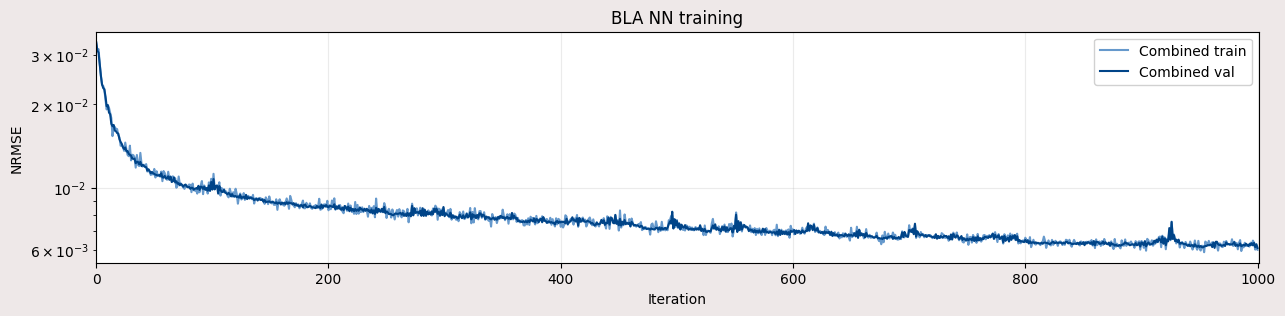

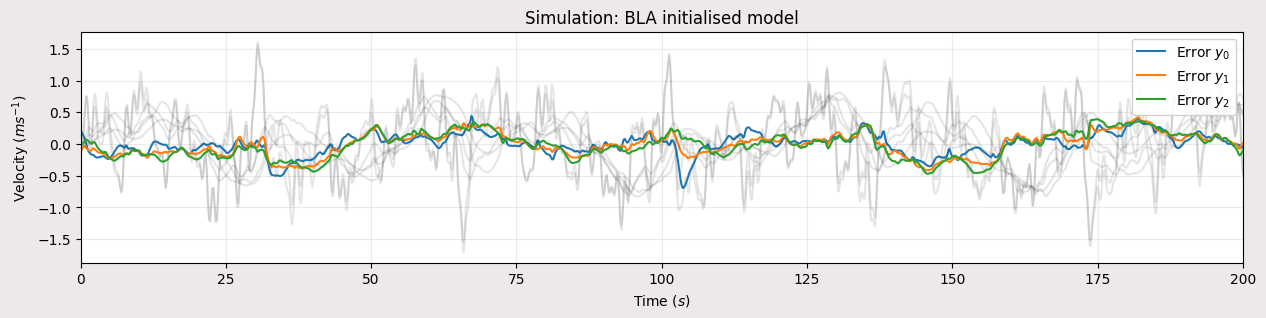

In [109]:
rest2_cf_loss, rest2_cf_val_loss, rest2_cf_best_sd = fit_model(combined_model, datasets[0]["dsi_IO"], datasets[1]["dsi_IO"], n_its=1001, T=100, val_freq=50)
plt.semilogy(rest2_cf_loss, label="Combined train", color="#6699CC")
plt.semilogy(rest2_cf_val_loss, label="Combined val", color="#004488")

plt.ylabel('NRMSE')
plt.legend(loc=1)
plt.xlabel('Iteration')
plt.xlim([0, max(len(lf_loss), len(nlf_loss), len(rest_cf_loss))])
plt.title("BLA NN training")    
plt.grid(alpha=0.25)
plt.show()

comb_states, comb_outputs = simulate_model_withP(sim_time=sim_time, model=combined_model, x0=x0, u_ext=u)
plot_simulation(sim_time, datasets[z]["output"], comb_outputs, plot_mode="error", title="Simulation: BLA initialised model")

In [116]:
NN_loss = torch.cat((rest_cf_loss, rest2_cf_loss)).shape
NN_val_loss = torch.cat((rest_cf_val_loss, rest2_cf_val_loss)).shape

cf_train = {
    "train_loss":NN_loss,
    "val_loss":NN_val_loss,
    "state_dict":cf_best_sd
}
torch.save(cf_train, PATH_MODEL_comb)

In [14]:
combined_model = combined_PHNN(system_dim, na, nb, dt=sim_time[1], x0=x_test,
                               Jinit=J,
                               Rinit=R,
                               Ginit=G,
                               Qinit=Q,
                               custom_kwargs={})

# If we have a saved model --> no need to train --> instead load the saved model statedict and training info
if os.path.isfile(PATH_MODEL_comb):
    cf_saved = torch.load(PATH_MODEL_comb, weights_only=False)
    combined_model.load_state_dict(cf_saved["state_dict"])
    cf_loss = cf_saved["train_loss"]
    cf_val_loss = cf_saved["val_loss"]
# Otherwise, we have to train the model and save it afterwards
else: 
    cf_loss, cf_val_loss, cf_best_sd = fit_model(combined_model, datasets[0]["dsi_IO"], datasets[1]["dsi_IO"], n_its=10001, T=1, val_freq=100)
    cf_train = {
        "train_loss":cf_loss,
        "val_loss":cf_val_loss,
        "state_dict":cf_best_sd
    }
    torch.save(cf_train, PATH_MODEL_comb)

  0%|          | 5/1001 [00:00<00:52, 19.03it/s]

Iteration       0, with training loss (NRMSE): 288.02661 and validation loss (NRMSE): 284.06305 === NEW BEST VALIDATION!


 10%|█         | 104/1001 [00:05<00:44, 20.08it/s]

Iteration     100, with training loss (NRMSE): 152.33656 and validation loss (NRMSE): 163.57881


 20%|██        | 204/1001 [00:10<00:40, 19.78it/s]

Iteration     200, with training loss (NRMSE): 152.71959 and validation loss (NRMSE): 152.77348


 30%|███       | 305/1001 [00:15<00:35, 19.35it/s]

Iteration     300, with training loss (NRMSE): 133.94572 and validation loss (NRMSE): 149.87787


 40%|████      | 403/1001 [00:20<00:29, 20.11it/s]

Iteration     400, with training loss (NRMSE): 143.98529 and validation loss (NRMSE): 147.84288


 50%|█████     | 504/1001 [00:25<00:25, 19.24it/s]

Iteration     500, with training loss (NRMSE): 120.92001 and validation loss (NRMSE): 144.73320 === NEW BEST VALIDATION!


 60%|██████    | 604/1001 [00:30<00:19, 19.89it/s]

Iteration     600, with training loss (NRMSE): 157.55045 and validation loss (NRMSE): 143.88644


 70%|███████   | 704/1001 [00:35<00:14, 19.96it/s]

Iteration     700, with training loss (NRMSE): 132.19667 and validation loss (NRMSE): 144.34064


 80%|████████  | 804/1001 [00:41<00:10, 19.62it/s]

Iteration     800, with training loss (NRMSE): 159.07234 and validation loss (NRMSE): 139.78168


 90%|█████████ | 904/1001 [00:46<00:04, 19.88it/s]

Iteration     900, with training loss (NRMSE): 125.79925 and validation loss (NRMSE): 134.49323


100%|██████████| 1001/1001 [00:51<00:00, 19.62it/s]

Iteration   1,000, with training loss (NRMSE): 128.15215 and validation loss (NRMSE): 126.84785


__Compare model class performances__
- Plot the training and validation losses over <font color='red'>_(1000)_</font> epochs
- Plot the qualitative simulation performance <font color='red'>_(all models in 1 plot will probably not be very informative, so instead plot $y_{1}$ simulation and combined n-step error)_</font>
- Summarize findings

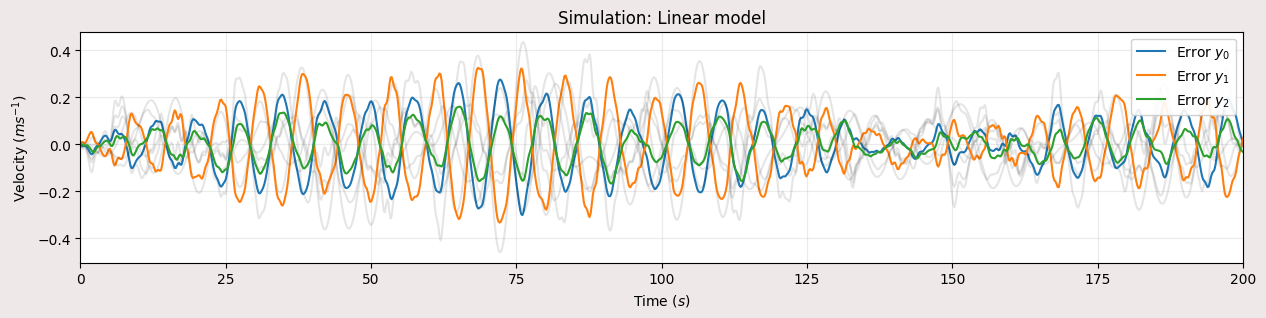

In [15]:
# Qualitative results of the linear model
lin_states, lin_outputs = simulate_model(sim_time=sim_time, model=linear_model, x0=x0, u_ext=u)
plot_simulation(sim_time, datasets[z]["output"], lin_outputs, plot_mode="error", title="Simulation: Linear model")

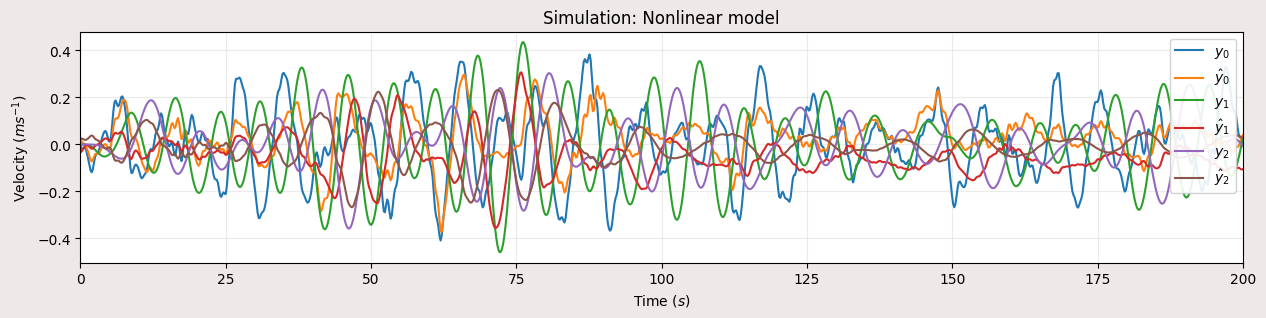

In [16]:
# Qualitative results of the linear model
nonlin_states, nonlin_outputs = simulate_model(sim_time=sim_time, model=nonlinear_model, x0=x0, u_ext=u)
plot_simulation(sim_time, datasets[z]["output"], nonlin_outputs, plot_mode="full_sim", title="Simulation: Nonlinear model")

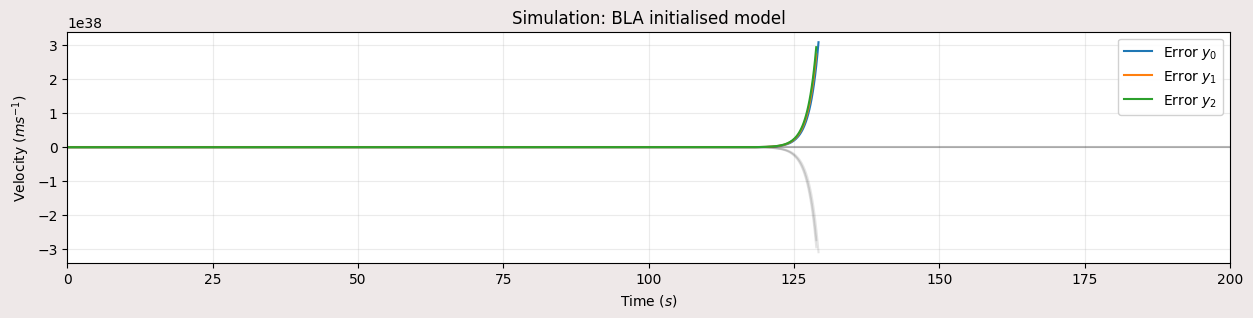

In [18]:
# Qualitative results of the linear model
comb_states, comb_outputs = simulate_model_withP(sim_time=sim_time, model=combined_model, x0=x0, u_ext=u)
plot_simulation(sim_time, datasets[z]["output"], comb_outputs, plot_mode="error", title="Simulation: BLA initialised model")

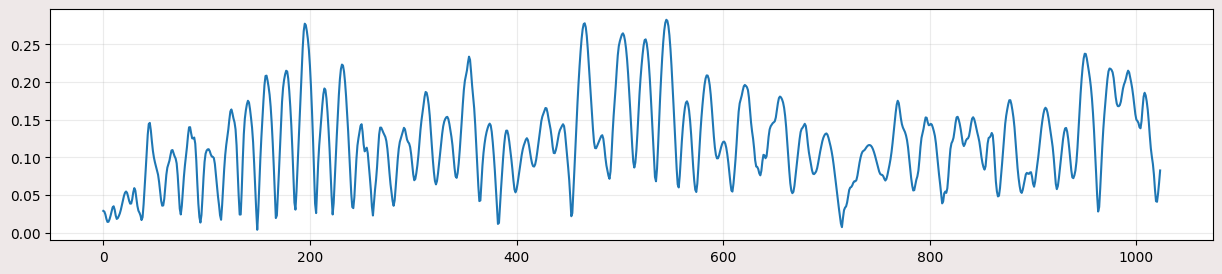

In [17]:
# Plot RMSE n-step error:
error = datasets[z]["output"] - nonlin_outputs
error.shape
rmse = torch.sqrt(torch.mean(torch.square(error), dim=1))
plt.plot(rmse)

In [18]:
combined_model = combined_PHNN(system_dim, na, nb, dt=sim_time[1], x0=x_test,
                               Jinit=J,
                               Rinit=R,
                               Ginit=G,
                               Pinit=P,
                               Qinit=Q,
                               custom_kwargs={})
_, _, G_test, _, P_test = combined_model.get_matrices(x_test)

tensor([0., 0., 0., 0., 0., 0.])
tensor([-1.7414e-05, -5.9198e-05,  3.1206e-04,  1.3014e-03,  8.6620e-05,
         4.5990e-04])
tensor([-3.1523e-05, -1.0318e-04,  5.6426e-04,  2.3521e-03,  1.6469e-04,
         8.3457e-04])
tensor([-3.9771e-05, -1.2316e-04,  7.1063e-04,  2.9602e-03,  2.2087e-04,
         1.0561e-03])
tensor([-4.7160e-05, -1.3664e-04,  8.4067e-04,  3.4992e-03,  2.7817e-04,
         1.2559e-03])
tensor([-6.0189e-05, -1.6520e-04,  1.0706e-03,  4.4533e-03,  3.6910e-04,
         1.6053e-03])
tensor([-7.9990e-05, -2.1059e-04,  1.4200e-03,  5.9039e-03,  5.0239e-04,
         2.1347e-03])
tensor([-0.0001, -0.0003,  0.0018,  0.0075,  0.0007,  0.0027])
tensor([-0.0001, -0.0003,  0.0022,  0.0089,  0.0008,  0.0033])
tensor([-0.0001, -0.0003,  0.0024,  0.0101,  0.0010,  0.0037])
tensor([-0.0002, -0.0003,  0.0027,  0.0111,  0.0012,  0.0041])
tensor([-0.0002, -0.0002,  0.0030,  0.0123,  0.0013,  0.0046])
tensor([-0.0002, -0.0002,  0.0034,  0.0139,  0.0016,  0.0052])
tensor([-0.0002, -0

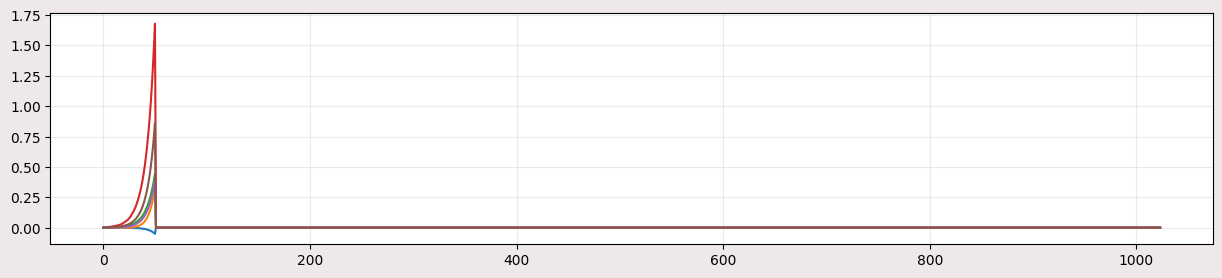

In [171]:
gu_vals = torch.zeros(len(sim_time), x0.shape[0])
a_vals = torch.zeros(len(sim_time), x0.shape[0])
states = torch.zeros(len(sim_time), x0.shape[0]) # Empty state tensor
outputs = torch.zeros(len(sim_time), u.shape[1])  # Empty output tensor
x = x0


for step, t_i in enumerate(sim_time):
    states[step, :] = x.detach()
    B = G+P
    Qx = torch.einsum("ij, j -> i", Q, x)
    outputs[step, :] = torch.einsum("ji, j -> i",  B, Qx)
    gu_vals[step, :] = torch.einsum("ik, k -> i", G-P, u[step, :])
    print(torch.einsum("ij, j -> i", J-R, Qx))
    a_vals[step, :] = torch.einsum("ij, j -> i", J-R, Qx)

    def deriv(xnow):
        Qx = torch.einsum("ij, j -> i", Q, xnow)
        func = torch.einsum("ij, j -> i", J-R, Qx) + torch.einsum("ik, k -> i", G-P, u[step, :])
        return func
    
    #x = RK4_multistep_integrator(deriv=deriv, dt=sim_time[1], x=x)
    #print(x)
    k1 = (dt) * deriv(x)            # t=0
    #print(k1)
    k2 = (dt/(2)) * deriv(x+k1/2)   # t=dt/2
    #print(k2)
    k3 = (dt/(2)) * deriv(x+k2/2)   # t=dt/2
    #print(k3)
    k4 = (dt) * deriv(x+k3)         # t=dt
    #print(k4)
    x = x + (k1 + 2*k2 + 2*k3 + k4)/6
    #print(x)
    if step == 50:
        break

plt.plot(states)

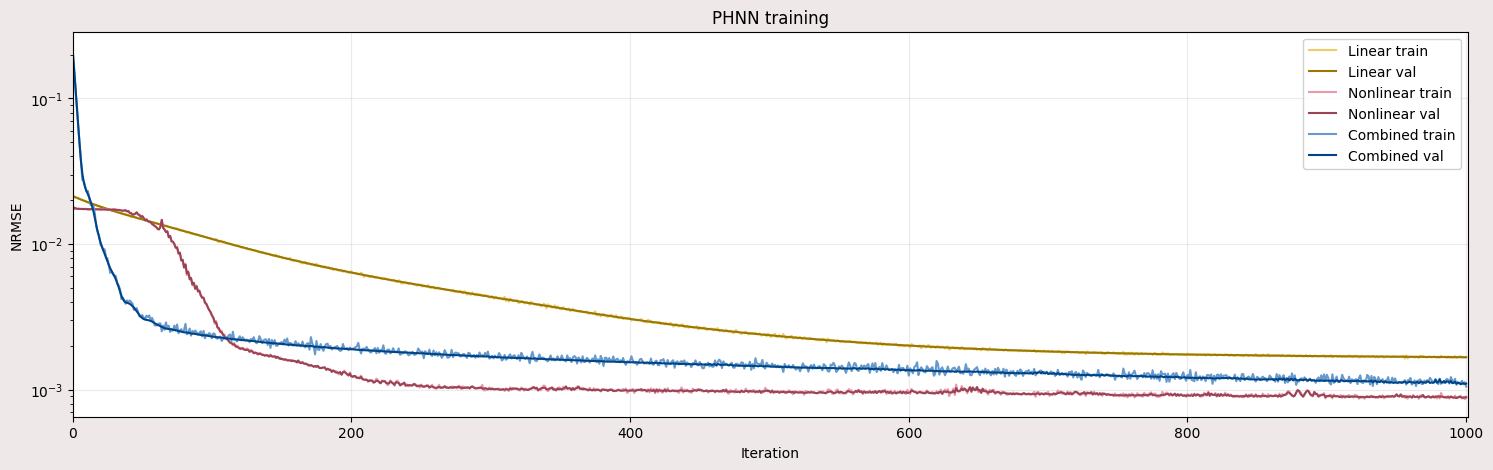

In [17]:
# Train times: 1hr for lin, 2.5hr for nonlin, ??? for comb
# Plot training progression:
fig = plt.figure(figsize=(18, 5))
plt.semilogy(lf_loss, label="Linear train", color="#EECC66")
plt.semilogy(lf_val_loss, label="Linear val", color="#997700")
plt.semilogy(nlf_loss, label="Nonlinear train", color="#EE99AA")
plt.semilogy(nlf_val_loss, label="Nonlinear val", color="#994455")
plt.semilogy(cf_loss, label="Combined train", color="#6699CC")
plt.semilogy(cf_val_loss, label="Combined val", color="#004488")

plt.ylabel('NRMSE')
plt.legend(loc=1)
plt.xlabel('Iteration')
plt.xlim([0, max(len(lf_loss), len(nlf_loss), len(cf_loss))])
plt.title("PHNN training")
plt.grid(alpha=0.25)
plt.show()